## 1  - Data Exploration

In [304]:
# imports 
import numpy as np
import pandas as pd 
import os
import random

# visualisation'
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style(style = 'darkgrid')
sns.set_palette('viridis')

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

## Reproducibility

In [305]:
train = pd.read_csv('train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [306]:
print('---Train data---')
print('Data Shape: {:,d} rows X {:d} columns'.format(train.shape[0], train.shape[1]))
print('Total no. of passengers: {:,d}'.format(len(train)))
# print('Number of unique tickets: {:d}'.format(train['Ticket'].nunique()))
print('Number of unique Passenger Classes: {:,d}'.format(train['Pclass'].nunique()))
print('Number of unique Fare amounts: {:,d}'.format(train['Fare'].nunique()))
print()

---Train data---
Data Shape: 891 rows X 12 columns
Total no. of passengers: 891
Number of unique Passenger Classes: 3
Number of unique Fare amounts: 248



In [307]:
for i in train.columns:
    print('Unique Values in ' + i + ' column: ' + str(len(train[i].unique())))

Unique Values in PassengerId column: 891
Unique Values in Survived column: 2
Unique Values in Pclass column: 3
Unique Values in Name column: 891
Unique Values in Sex column: 2
Unique Values in Age column: 89
Unique Values in SibSp column: 7
Unique Values in Parch column: 7
Unique Values in Ticket column: 681
Unique Values in Fare column: 248
Unique Values in Cabin column: 148
Unique Values in Embarked column: 4


## 1.1 Feature Exploration

Categorical and Continuos Features

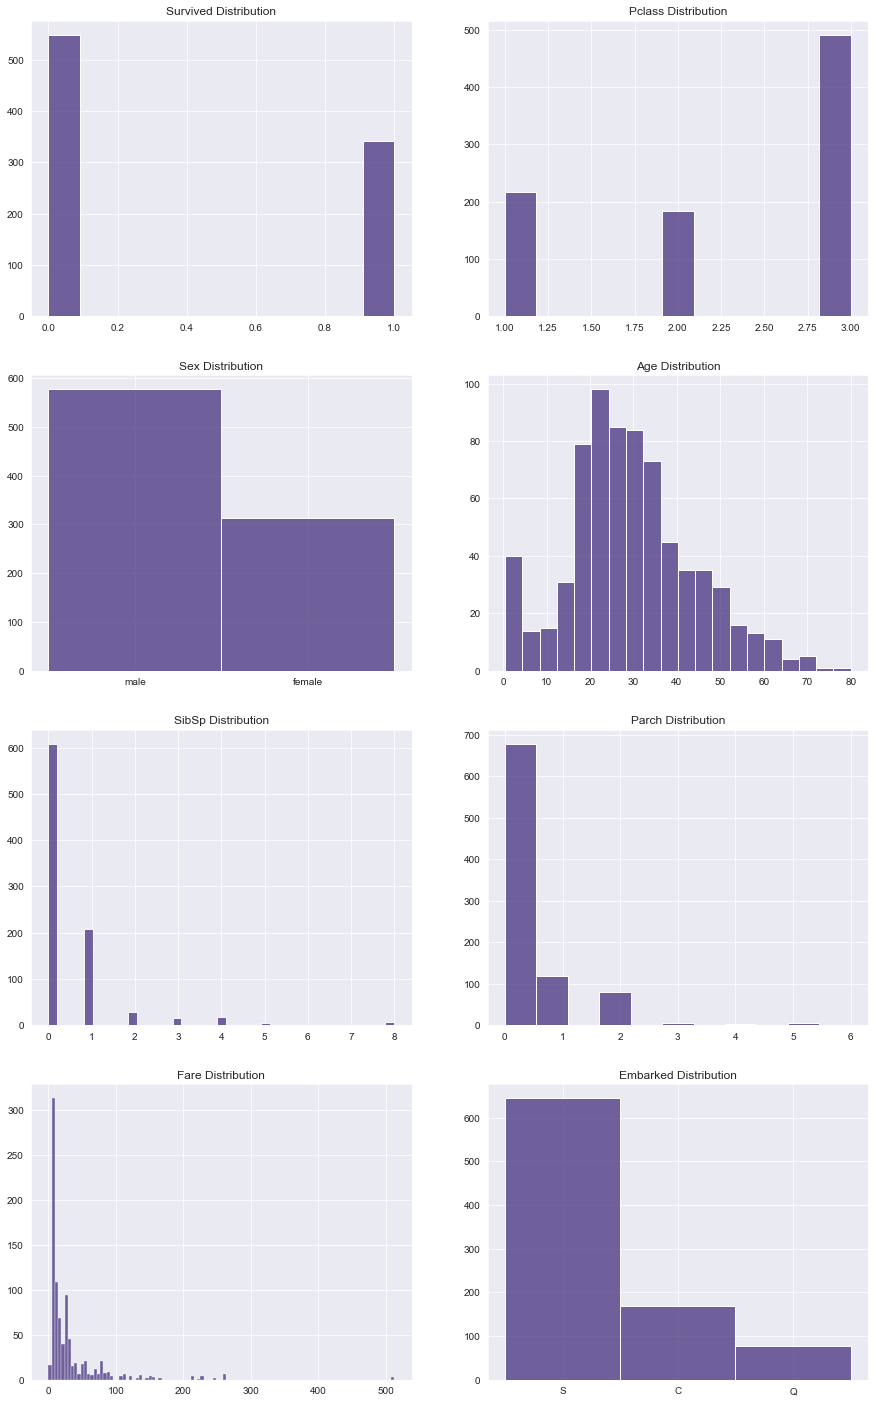

In [308]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, figsize =(15,25))

train_copy = train.copy()
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
axs = axs.flatten()

for i, feature in enumerate(features):
    _ = sns.histplot(train_copy, x="{}".format(feature), ax=axs[i])
    _ = axs[i].set_title("{} Distribution".format(feature))
    _ = axs[i].set_ylabel("")
    _ = axs[i].set_xlabel("")

## 1.2 Spearman Correlation

<AxesSubplot:>

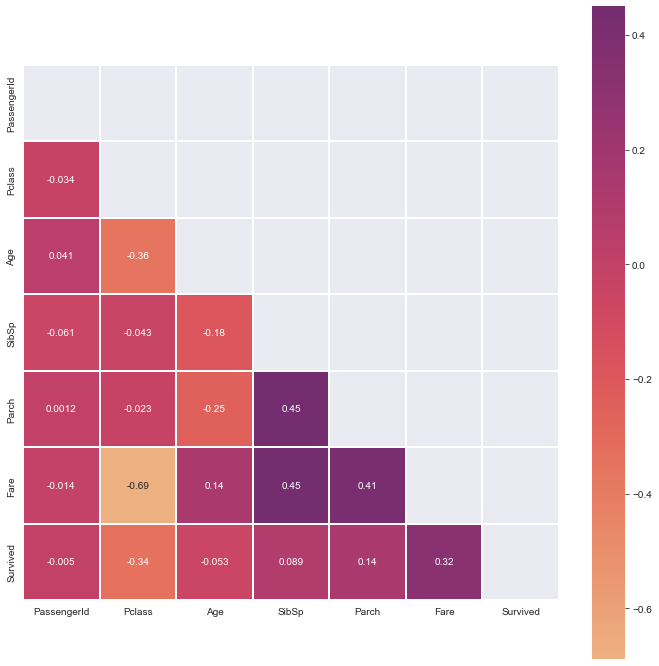

In [309]:
plt.figure(figsize = (12,12))
features = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
           'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

corr_matrix = train[features].corr('spearman')
sns.heatmap(corr_matrix, 
            annot = True, 
            cmap = 'flare', 
            mask = np.triu(np.ones_like(corr_matrix, dtype = bool)),  
            center = 0,
            square = True, 
            linewidths = 0.1 )

## 2 - Missing Data

In [310]:
print('Percentage of missing data per feature in the train set:')
100 * train.isnull().sum() / len(train)

Percentage of missing data per feature in the train set:


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

## 2.1 Age (Train)

In [311]:
features = ["Age"]
train[features].describe().T.style.bar(
    subset=['mean'], color='#7BCC70')\
    .background_gradient(subset=['std'], cmap='Reds')\
    .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000


<AxesSubplot:xlabel='Age', ylabel='Count'>

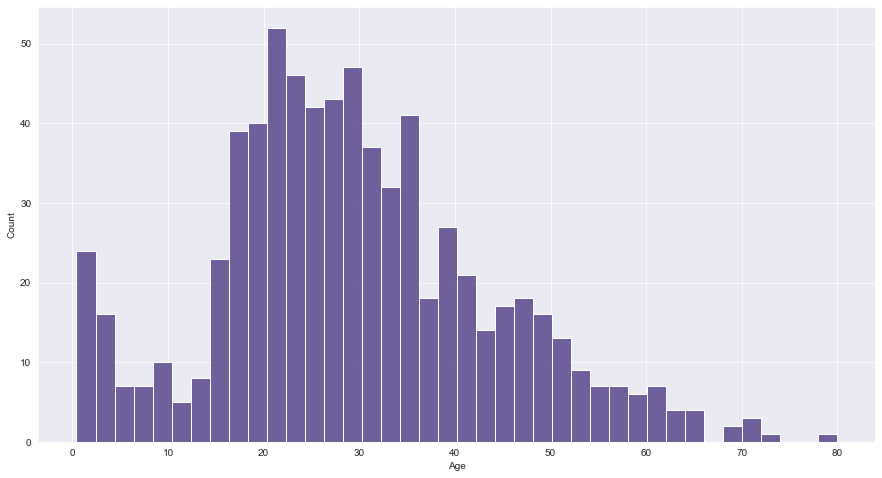

In [312]:
plt.figure(figsize = (15, 8))
sns.histplot(x = 'Age', data = train, palette = 'flare', bins = 40)

In [313]:
print('Age grouped by Pclass:') 
train.groupby('Pclass')['Age'].describe().style.bar(
     subset=['mean'], color = '#7BCC70')\
    .background_gradient(subset = ['std'], cmap = 'flare')\
    .background_gradient(subset = ['50%'], cmap = 'flare') 

Age grouped by Pclass:


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.000000,38.233441,14.802856,0.920000,27.000000,37.000000,49.000000,80.000000
2,173.000000,29.877630,14.001077,0.670000,23.000000,29.000000,36.000000,70.000000
3,355.000000,25.140620,12.495398,0.420000,18.000000,24.000000,32.000000,74.000000


In [314]:
 print('Age grouped by Sex:') 
train.groupby('Sex')['Age'].describe().style.bar(
     subset=['mean'], color = '#7BCC70')\
    .background_gradient(subset = ['std'], cmap = 'flare')\
    .background_gradient(subset = ['50%'], cmap = 'flare') 

Age grouped by Sex:


,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.000000,27.915709,14.110146,0.750000,18.000000,27.000000,37.000000,63.000000
male,453.000000,30.726645,14.678201,0.420000,21.000000,29.000000,39.000000,80.000000


In [315]:
# utility 
data_train = train.groupby(['Pclass','Sex'])['Age'].mean()
print("Age grouped by Pclass and Sex in the train data:")
data_train

Age grouped by Pclass and Sex in the train data:


Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [316]:
# function to fill null age values in the train set
def fill_train_age(pclass, sex, age):
    '''
    takes in the pclass, sex and age 
    if the age is null, then extracts the age from 'data'and returns the corrosponding age
    else returns the original age
    '''
    if np.isnan(age): 
        return data_train.loc[(pclass, sex)]
    else: 
        return age
    
# filling the missing values
train['Age'] = train.apply(lambda x: fill_train_age(x['Pclass'], x['Sex'], x['Age']), axis=1)       

## 2.2 Embarked (Train only)

In [317]:
# storing the most common 'Embarked' value
common_value = train['Embarked'].value_counts().idxmax()

In [318]:
# filling all null values
train['Embarked'] =train['Embarked'].fillna(common_value)

In [319]:
# check
train['Embarked'].isnull().sum()

0

## 2.3 Cabin (Train & Test)

Turns out, the first letter of the Cabin signifies the decks on which the cabins are located. Let's first explore this furthur

In [320]:
train['Deck'] = train['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')

In [321]:
print('Train data grouped by Deck and Pclass:')
train.groupby(['Deck', 'Pclass']).size().reset_index(name = 'Counts')

Train data grouped by Deck and Pclass:


,Deck,Pclass,Counts
0,A,1,15
1,B,1,47
2,C,1,59
3,D,1,29
4,D,2,4
5,E,1,25
6,E,2,4
7,E,3,3
8,F,2,8
9,F,3,5


In [322]:
train['Deck'] = train['Deck'].replace(['A', 'B', 'C', 'T'], 'ABC')
train['Deck'] = train['Deck'].replace(['D', 'E'], 'DE')
train['Deck'] = train['Deck'].replace(['F', 'G'], 'FG')

## 3  - Feature Engineering

## 3.1 Extracting titles from 'Name' 
We cannot use the whole name as there are a lot of unique names. But all the names have a title that is associated with the person. We can extract the titles and convert them into dummies.


In [323]:
# storing the most common titles 
titles = ['Mr', 'Miss', 'Mrs', 'Master', 'Other', 'Mlle', 'Ms', 'Mme']

In [324]:
# function to extract the tile 
def extract_title(name):
    '''
    takes in the name feature
    splits the name based on space and creates a list 
    stores in the 2nd item (title) in the variable 'title'
    
    if the title is not among the common titles, returns 'Other'
    else returns the title 
    '''

    title = name.split('.')[0].split(' ')[-1]
    
    if title not in titles:
        return titles[4]
    else:
        return title


In [325]:
# extracting the title in a different coulmn
train['Title'] = train.apply(lambda x: extract_title(x['Name']), axis=1) 

In [326]:
# replacing 
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')


## 3.2 Fam size

In [327]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,M,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,ABC,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,M,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,ABC,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,M,Mr


<AxesSubplot:xlabel='Fam Size', ylabel='Count'>

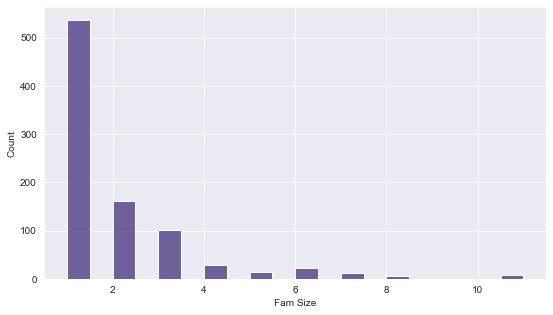

In [328]:
train['Fam Size'] = train['SibSp'] + train['Parch'] + 1
plt.figure(figsize = (9, 5))
sns.histplot(x = 'Fam Size', data = train, binwidth= 0.5 )

In [329]:
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}

train['Fam Size grouped'] = train['Fam Size'].map(family_map)

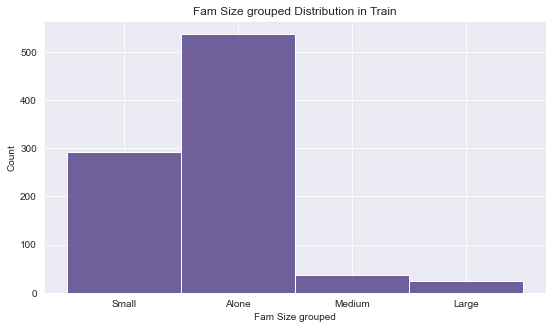

In [330]:
plt.figure(figsize = (9, 5))
sns.histplot(x = 'Fam Size grouped', data = train, binwidth= 0.5).set_title("Fam Size grouped Distribution in Train")
plt.show()

## 3.3 Age 

In [331]:
train['Age'].value_counts()

26.507589    94
21.750000    42
24.000000    30
22.000000    27
18.000000    26
             ..
14.500000     1
70.500000     1
12.000000     1
36.500000     1
74.000000     1
Name: Age, Length: 94, dtype: int64

In [332]:
train['Age'].isnull().sum()

0

In [333]:
train.isnull().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
Deck                  0
Title                 0
Fam Size              0
Fam Size grouped      0
dtype: int64

### bins = [0,10, 20, 30, 40, 50, 60, 80]
labels=['babies','teens','20s', '30s','40s','50s','oldage']

train['Age group'] = pd.cut(train['Age'], bins, labels=labels)

age_map = {'babies': 1, 'teens': 2, '20s': 3, '30s': 4, '40s': 5, '50s': 6, 'oldge': 7}
train['Age group'] = pd.to_numeric(train['Age group'].map(age_map))

### train.loc[train['Age'] <= 16, 'Age'] = 0
train.loc[(train['Age'] > 16) & (train['Age'] <= 26), 'Age'] = 1
train.loc[(train['Age'] > 26) & (train['Age'] <= 36), 'Age'] = 2
train.loc[(train['Age'] > 36) & (train['Age'] <= 62), 'Age'] = 3
train.loc[train['Age'] > 62, 'Age'] = 4
   

In [334]:
train.isnull().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
Deck                  0
Title                 0
Fam Size              0
Fam Size grouped      0
dtype: int64

In [335]:
bins = [0,10, 20, 30, 40, 50, 60, 80]
labels=['babies','teens','20s', '30s','40s','50s','oldge']

train['Age group'] = pd.cut(train['Age'], bins, labels=labels)


age_map = {'babies': 1, 'teens': 2, '20s': 3, '30s': 4, '40s': 5, '50s': 6, 'oldge': 7}
train['Age group'] = pd.to_numeric(train['Age group'].map(age_map))


In [336]:
train.isnull().sum()

PassengerId           0
Survived              0
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin               687
Embarked              0
Deck                  0
Title                 0
Fam Size              0
Fam Size grouped      0
Age group             0
dtype: int64

## 3.4 Fare

In [337]:
train['Fare'] = pd.qcut(train['Fare'], 13)

In [338]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Title,Fam Size,Fam Size grouped,Age group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,"(7.229, 7.75]",NaN,S,M,Mr,2,Small,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,"(55.9, 83.158]",C85,C,ABC,Mrs,2,Small,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,"(7.896, 8.05]",NaN,S,M,Miss,1,Alone,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,"(33.308, 55.9]",C123,S,ABC,Mrs,2,Small,4
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,"(7.896, 8.05]",NaN,S,M,Mr,1,Alone,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,"(10.5, 13.0]",NaN,S,M,Other,1,Alone,3
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,"(26.55, 33.308]",B42,S,ABC,Miss,1,Alone,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.75,1,2,W./C. 6607,"(15.85, 24.0]",NaN,S,M,Miss,4,Small,3
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,"(26.55, 33.308]",C148,C,ABC,Mr,1,Alone,3


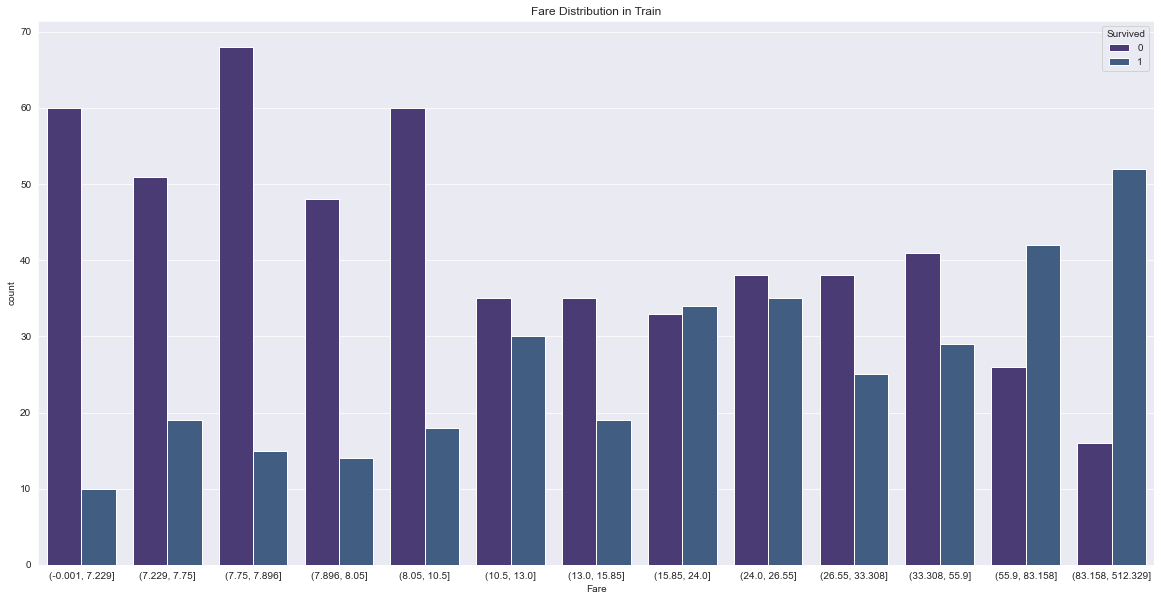

In [339]:
plt.figure(figsize = (20, 10))
sns.countplot(x = 'Fare', data = train, hue = 'Survived').set_title("Fare Distribution in Train")
plt.show()

## 4 - Data Processing

* Dropping columns that are not useful
* Label encoding
* One hot encoding
* Scaling 
* Data Split

## 4.1 Dropping Unhelpful Data

In [340]:
# dropping columns that are not helpful
train_df = train.drop(['Name', 'PassengerId', 'Ticket','Age', 'SibSp', 'Parch', 'Cabin', 'Fam Size'], axis = 1)

In [341]:
train_df.head(1)

,Survived,Pclass,Sex,Fare,Embarked,Deck,Title,Fam Size grouped,Age group
0,0,3,male,"(7.229, 7.75]",S,M,Mr,Small,3


In [342]:
train_df.isnull().sum()

Survived            0
Pclass              0
Sex                 0
Fare                0
Embarked            0
Deck                0
Title               0
Fam Size grouped    0
Age group           0
dtype: int64

## 4.2 Label encoding

In [343]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
non_numeric_features = ['Embarked', 'Fare', 'Sex', 'Deck', 'Title', 'Fam Size grouped', 'Age group']

for feature in non_numeric_features:        
    train[feature] = LabelEncoder().fit_transform(train[feature])
print('Encoding for train finished!')

Encoding for train finished!


## 4.3 One Hot Encoding

In [344]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Fam Size grouped']
encoded_features = []

for feature in cat_features:
    encoded_feat = OneHotEncoder().fit_transform(train_df[feature].values.reshape(-1, 1)).toarray()
    n = train_df[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_df = pd.DataFrame(encoded_feat, columns=cols)
    encoded_df.index = train_df.index
    encoded_features.append(encoded_df)
    
train_df = pd.concat([train_df, *encoded_features[:6]], axis=1)

In [345]:
# change dtype for Fare for scaling
train_df['Fare'] = train_df['Fare'].apply(lambda x: x.mid).astype(float)

In [346]:
drop_cols = ['Sex', 'Embarked', 'Deck', 'Title', 'Fam Size grouped','Pclass']

train_df = train_df.drop(columns = drop_cols)

## 4.4 Labels

In [347]:
# define the labels
X = train_df.drop(['Survived'], axis = 1)
y = train_df['Survived'].values

In [348]:
from sklearn.model_selection import train_test_split

In [349]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=0)

In [350]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

X_train shape: (846, 23)
y_train shape: (846,)


In [351]:
# utility
train_columns = X_train.columns

## 4.5 Scaling

In [352]:
# import 
from sklearn.preprocessing import StandardScaler

# creating an instance of the scaler
scaler = StandardScaler()

# using .fit_transform() on the train and val data
X_train = scaler.fit_transform(X_train)

## 4.6 Data Split

In [353]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = seed_value)

In [354]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,-0.394168,1.198979,-0.561879,1.958133,-1.112697,-0.735516,0.735516,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,-0.508850,-1.181779,-0.406558,6.267832,0.815693,-0.174501,-0.204626,-0.701472
1,-0.427694,-0.305971,-0.561879,-0.510690,0.898717,-0.735516,0.735516,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,-0.508850,0.846182,-0.406558,-0.159545,0.815693,-0.174501,-0.204626,-0.701472
2,-0.451880,-0.305971,-0.561879,-0.510690,0.898717,-0.735516,0.735516,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,-0.508850,0.846182,-0.406558,-0.159545,0.815693,-0.174501,-0.204626,-0.701472
3,0.050861,-1.810921,-0.561879,1.958133,-1.112697,-0.735516,0.735516,-0.390626,-0.286079,6.983173,...,0.611046,4.611199,-0.508850,-1.181779,-0.406558,-0.159545,-1.225952,-0.174501,-0.204626,1.425573
4,-0.445330,0.446504,-0.561879,-0.510690,0.898717,-0.735516,0.735516,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,-0.508850,0.846182,-0.406558,-0.159545,0.815693,-0.174501,-0.204626,-0.701472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,-0.357934,-0.305971,-0.561879,-0.510690,0.898717,1.359590,-1.359590,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,-0.508850,-1.181779,2.459675,-0.159545,-1.225952,-0.174501,-0.204626,1.425573
672,-0.394168,-0.305971,-0.561879,-0.510690,0.898717,1.359590,-1.359590,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,1.965215,-1.181779,-0.406558,-0.159545,0.815693,-0.174501,-0.204626,-0.701472
673,-0.210963,0.446504,1.779744,-0.510690,-1.112697,-0.735516,0.735516,-0.390626,3.495533,-0.143201,...,0.611046,-0.216863,-0.508850,0.846182,-0.406558,-0.159545,0.815693,-0.174501,-0.204626,-0.701472
674,-0.283432,0.446504,-0.561879,-0.510690,0.898717,-0.735516,0.735516,-0.390626,-0.286079,-0.143201,...,0.611046,-0.216863,-0.508850,0.846182,-0.406558,-0.159545,-1.225952,-0.174501,-0.204626,1.425573


In [355]:
pd.DataFrame(X_test)

,Fare,Age group,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Deck_1,Deck_2,Deck_3,...,Embarked_3,Title_1,Title_2,Title_3,Title_4,Title_5,Fam Size grouped_1,Fam Size grouped_2,Fam Size grouped_3,Fam Size grouped_4
495,14.4250,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
648,7.4895,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
278,29.9290,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
31,297.7435,4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
255,14.4250,3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
298,29.9290,5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
609,297.7435,4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
318,297.7435,4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
484,297.7435,3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
367,3.6140,3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## 5 - Model

* Creating a Random Forest Classifier
* Get the best estimator via GridSearch
* Re-train with the best estimator
* Cross Validation
* Feature Importance
* Submission

## 5.1 Model 

The `StratifiedKfold` val paired with `N_estimators` and `max_depth` had majority of impact in bumping the `val_score` from 0.79 to 0.83

In [356]:
clf = RandomForestClassifier(n_estimators = 1170, 
                             oob_score = True,
                             max_depth = 7, # makes the most difference  
                             min_samples_split=6, 
                             min_samples_leaf=6,
                             max_features='auto',
                             random_state = seed_value, 
                             verbose = 1)

## 5.2 StratifiedKFold

In [357]:
X_train

array([[-0.39416841,  1.19897891, -0.56187865, ..., -0.1745012 ,
        -0.2046263 , -0.70147237],
       [-0.42769398, -0.30597088, -0.56187865, ..., -0.1745012 ,
        -0.2046263 , -0.70147237],
       [-0.45187979, -0.30597088, -0.56187865, ..., -0.1745012 ,
        -0.2046263 , -0.70147237],
       ...,
       [-0.21096306,  0.44650402,  1.77974371, ..., -0.1745012 ,
        -0.2046263 , -0.70147237],
       [-0.28343246,  0.44650402, -0.56187865, ..., -0.1745012 ,
        -0.2046263 ,  1.42557289],
       [-0.21096306,  1.19897891, -0.56187865, ..., -0.1745012 ,
        -0.2046263 ,  1.42557289]])

In [358]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train_columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=20200226, shuffle=True)

for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    clf.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], clf.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], clf.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = clf.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = clf.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = clf.feature_importances_
        
    oob += clf.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, clf.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished


Fold 1 OOB Score: 0.8203703703703704

Fold 2



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished


Fold 2 OOB Score: 0.8170055452865065

Fold 3



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished


Fold 3 OOB Score: 0.8317929759704251

Fold 4



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished


Fold 4 OOB Score: 0.8170055452865065

Fold 5



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fold 5 OOB Score: 0.8280961182994455

Average OOB Score: 0.8228541110426508


[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished


## 5.3 Feature Importance

In [359]:
importances = pd.DataFrame({'feature':train_columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

print('Feature Importance:')
importances

Feature Importance:


,importance
feature,
Title_3,0.172
Sex_1,0.168
Sex_2,0.168
Pclass_3,0.073
Fare,0.072
Title_4,0.050
Age group,0.043
Deck_4,0.040
Title_2,0.037


<AxesSubplot:xlabel='feature'>

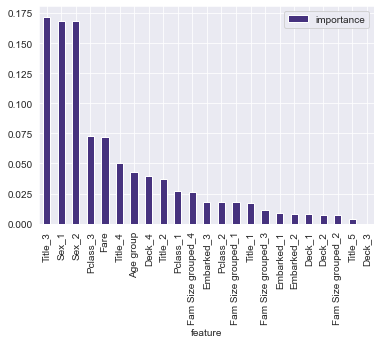

In [360]:
importances.plot.bar()

## 5.4 Evaluation

In [361]:
predictions = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1170 out of 1170 | elapsed:    0.0s finished


In [364]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print('Classification Report:')
print()
print(classification_report(y_test, predictions))

Classification Report:

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        25
           1       0.00      0.00      0.00        20

    accuracy                           0.56        45
   macro avg       0.28      0.50      0.36        45
weighted avg       0.31      0.56      0.40        45



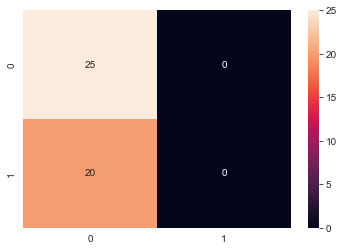

In [363]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

In [295]:
import pickle

Pkl_Filename = "random_forest.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

In [296]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    rf_tuned_loaded = pickle.load(file)

In [297]:
rf_tuned_loaded

RandomForestClassifier(max_depth=7, min_samples_leaf=6, min_samples_split=6,
                       n_estimators=1170, oob_score=True, random_state=42,
                       verbose=1)